In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

We are using data from the UCI Machine Learning Repisotory, specifically the [default of credit card clients dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), in order to predict if someone will default on their credit card payments based on numerous metrics such as sex, age, marital status and many others.

In [36]:
df = pd.read_csv(r"/Users/theoeudes/Desktop/Data Science/default_credit_card_clients.tsv", 
                 header=1, sep='\t') ## NOTE: The second line contains column names, so we skip the first line

df.rename({'default payment next month' : 'DEFAULT'}, axis='columns', inplace=True)
df.head(10)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


We can see a lot of variables in our dataset 

- **ID** : The ID number assigned to each customer
- **LIMIT_BAL** : Amount of the given credit
- **SEX** : Gender (1 = male; 2 = female)
- **EDUCATION** : Level of education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
- **MARRIAGE** : Marital status (1 = married; 2 = single; 3 = others)
- **AGE** : Age (years)
- **PAY_** : History of past payment, tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- **BLL_AMT** : What the last 6 bills were: X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- **PAY_AMT** : Amount of the last payments were: X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.
- **DEFAULT** (1= Yes; 0=No)



## Data preprocessing

We can see there is a lot of variables in our dataset, some more useful than others, we can drop ID because it's doesn't give us information for our task.

In [37]:
df.drop('ID', axis=1, inplace=True)

First and foremost, we have to check if we have missing values and deal with them

In [38]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

All of our varibales are numeric characters, which means we don't have a mix of letters and numbers. In other words, there are no **NA** values, or other character based place holders for missing data, in **df**.

We also have categorical variables, we should check for **NA** too

In [39]:
df['SEX'].unique(), df['EDUCATION'].unique() , df['MARRIAGE'].unique()

(array([2, 1]), array([2, 1, 3, 5, 4, 6, 0]), array([1, 2, 3, 0]))

# Missing Data Part 2: Dealing With Missing Data

Since scikit-learn's support vector machines do not support datasets with missing values, we need to figure out what to do with  the 0s in the dataset. We can either delete these customers from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [40]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)]), len(df)

(68, 30000)

68 values out of 3000 could be missings values, since it's ~1% of our global values, we still have much than necessary to perform our Support Vector Machines, so we don't need to replace the missing values we can just erase the row with 0 in the database

In [41]:
df_cleaned = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]

In [42]:
len(df_cleaned)

29932

In [43]:
df_cleaned['EDUCATION'].unique() , df_cleaned['MARRIAGE'].unique()

(array([2, 1, 3, 5, 4, 6]), array([1, 2, 3]))

# Downsample the data

**Support Vector Machines** are great with small datasets, but not awesome with large ones, and this dataset is big enough to take a long time to optimize with Cross Validation. So we will downsample both categories, customers who did and did not default to 1,000 each.

To make sure we get **1,000** of each category, we start by splitting the data into two dataframes /

- one for people that did not default 
- one for people that did default

In [44]:
df_no_default = df_cleaned[df_cleaned['DEFAULT'] == 0]
df_default = df_cleaned[df_cleaned['DEFAULT'] == 1]

In [45]:
df_no_default_downsampled = resample(df_no_default,
                                  replace=False,
                                  n_samples=1000,
                                  random_state=42)
len(df_no_default_downsampled)

df_default_downsampled = resample(df_default,
                                  replace=False,
                                  n_samples=1000,
                                  random_state=42)
len(df_default_downsampled)

1000

In [46]:
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsample)

2000

# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making a **Support Vector Machine**.

1. The columns of data that we will use to make classifications
2. The column of data that we want to predict (whether or not someone defaulted on a payment).

In [47]:
X = df_downsample.drop('DEFAULT', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1].copy()
X.head()

y = df_downsample['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

# Format the Data Part 2: One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list bellow tells us what each variable represents and the type of data (**Int** or **Categorical**) it should contain:

- **LIMIT_BAL**, The amount of available credit **Integer**
- **SEX**, **Category**
  - 1 = male
  - 2 = female
- **EDUCATION**, **Category**
  - 1 = graduate school
  - 2 = university
  - 3 = high school
  - 4 = others
- **MARRIAGE**, **Category**
  - 1 = Married
  - 2 = Single
  - 3 = Other
- **AGE**, **Integer**
- **PAY_**, When the last 6 bills were payed **Category**
  - -1 = Paid on time
  - 1 = Payment delayed by 1 month
  - 2 = Payment delayed by 2 months
  - ...
  - 8 = Payment delayed by 8 months
  - 9 = Payment delayed by 9 or more months
- **BILL_AMT**, What the last 6 bills were **Integer**
- **PAY_AMT**, How much the last payments were **Integer**
- **DEFAULT**, Whether or not a person defaulted on the next payment **CATEGORY**
  - 0 = Did not default
  - 1 = Defaulted
  
  
It looks like **SEX**, **EDUCATION**, **MARRIAGE** and **PAY_** are supposed to be categorical and need to be modified. This is because, while **Support Vector Machines** from scikit-learn natively support continuous data, like **LIMIT_BAL** and **AGE**, they do not natively support categorical data, like **MARRIAGE**, which contains three different categories. In order to use categorical data, we have to converts a column of categorical data into multiple columns of binary values via One-Hot Encoding.

In [48]:
X_encoded = pd.get_dummies(X, columns=['SEX',
                                       'EDUCATION',
                                       'MARRIAGE', 
                                       'PAY_0',
                                       'PAY_2',
                                       'PAY_3',
                                       'PAY_4',
                                       'PAY_5',
                                       'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


# Format the Data Part 3: Centering and Scaling

The **Radial Basis Function (RBF)** that we are using with our Support Vector Machine assumes that the data are centered and scaled. In other words, each column should have a $\mu=0$ and a $\sigma=1$. We need to do this to both the training and testing datasets.

**PS:** We split the data into training and testing datasets and then scale them separately to avoid Data Leakage.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preliminary Support Vector Machine

In [52]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

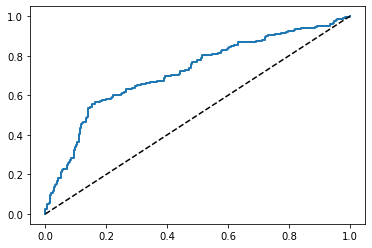

0.7182110774847481

In [53]:
y_score = clf_svm.decision_function(X_test_scaled)

fpr, tpr, _ = roc_curve(y_test, y_score)

def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr,tpr)

plt.show()
roc_auc_score(y_test, y_score)

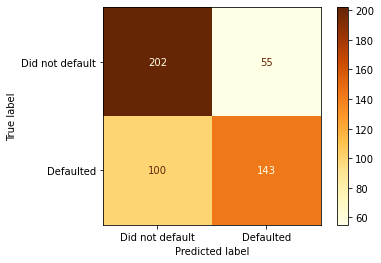

In [54]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test,
                      values_format='d',
                      cmap=plt.cm.YlOrBr,
                      display_labels=["Did not default", "Defaulted"])

For the ROC, the area under the curve, which measure the ability of a classifier to distinguish between classes is 0.72 (a perfect classifier woul have return 1). 

In the confusion matrix, we see that of the **257** people that did not default, **202 (79%)** were correctly classified. And of the **243** people that defaulted, **143 (59%)** were correctly classified. The **Support Vector Machine** was not really great without optimization.

So let's try to improve predictions using **Cross Validation** to optimize the parameters.

# Optimize Parameters with Cross Validation and GridSearchCV()

Optimizing a **Support Vector Machine** is all about finding the best value for **gamma**, and, potentially, the regularization parameter, **C**.


Let's see if we can find better parameters values using cross validation in hope that we can improve the accuracy with the **Testing Dataset**.

Since we have two parameters to optimize, we will use `GridSearchCV()`.

In [55]:
param_grid = [
  {'C': [0.5, 1, 10, 100], # NOTE: Values for C must be > 0
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]
## NOTE: We are includeing C=1 and gamma='scale'
## as possible choices since they are the default values.

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0 
    )

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


We see that the ideal value for `C` is **100** (we will use regularization) and the ideal value for `gamma` is **0.001**.

# Building, Evaluating, Drawing and Interpreting the Final Support Vector Machine

Now that we have the ideal values for `C` and `gamma` we can build the final **Support Vector Machine**:

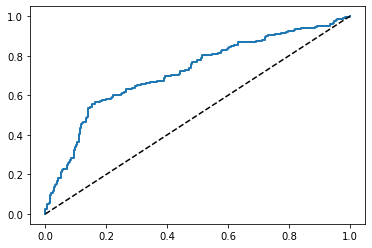

0.7182110774847481

In [56]:
y_score = clf_svm.decision_function(X_test_scaled)


fpr, tpr, _ = roc_curve(y_test, y_score)
def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
plot_roc_curve(fpr,tpr)

plt.show()
roc_auc_score(y_test, y_score)

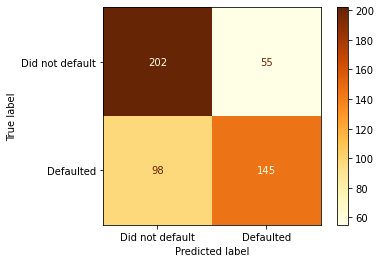

In [57]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test,
                      values_format='d',
                      cmap=plt.cm.YlOrBr,
                      display_labels=["Did not default", "Defaulted"])

The results from the **optimized** Support Vector Machine are :

FOr the ROC, the area under the curve doesn't change


For the confusion matrix, it's just a little bit better than before, **2** more people were correctly classified as defauting. So, the SVM was pretty good without much optimization. The last thing we are going to do is draw a support vector machine decision boundary and see how to interpret it.

In [22]:
len(df_downsample.columns)

24

There are 24 features columns, in X. This is a problem because it would require a 24-dimensional graph, one dimension per feature used to make predictions, to plot the data in its raw form. We will use PCA (Principal Component Analysis) to combine the 24 features into 2 orthogonal meta-features that we can use as axes for a graph.

However, before we shrink the graph, let's first determine how accurate the shrunken graph will be. If it's relatively accurate, than it makes sense to draw the 2-Dimensional graph. If not, the shrunken graph will not be very useful. We can determine the accuracy of the graph by drawing something called a scree plot.

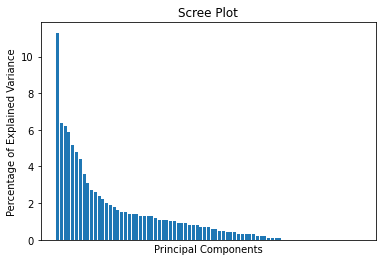

In [26]:
pca = PCA() #By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data, and this means that it will be a good candidate for the x-axis in the 2-dimensional graph. However, PC2 is not much different from PC3 or PC4, which doesn't bode well for dimension reduction.

In [24]:
train_pc1_coords = X_train_pca[:, 0] 
train_pc2_coords = X_train_pca[:, 1]

## NOTE:
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

# Centering and scaling
pca_train_scaled = preprocessing.scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

## We optimize the SVM fit to the x and y-axis coordinates of the data after PCA dimension reduction:
param_grid = [
  {'C': [1, 10, 100, 1000], 
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   14.5s finished


We have the optimal values for `C` and `gamma`, the graph is:

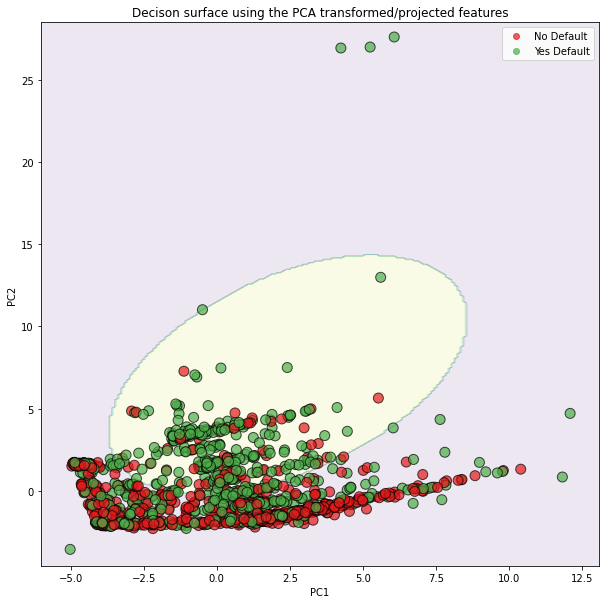

In [25]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
clf_svm.fit(pca_train_scaled, y_train)


X_test_pca = pca.transform(X_train_scaled) # Transformed test dataset with the PCA

test_pc1_coords = X_test_pca[:, 0] 
test_pc2_coords = X_test_pca[:, 1]


x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx, yy, Z, alpha=0.1)

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train, 
               cmap=cmap, 
               s=100, 
               edgecolors='k',
               alpha=0.7)


legend = ax.legend(scatter.legend_elements()[0], 
                   scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")


ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decison surface using the PCA transformed/projected features')

plt.show()

The pink part of the graph is the area were all datapoints will be predicted to have *not defaulted*. The yellow part of the graph is the area where all datapoints will be predicted to *have defaulted*. The the dots are datapoints in the training dataset and are color coded by their known classifications: red is for those that did *not default* and green is for those that *defaulted*.

**PS:** The results are show the training data, not the testing data and thus, do not match the confusion matrices that we generated. Also, for this graph, we only fit the SVM to the first two principal components instead of all the data, and thus, this is only an approximation of the true classifier. Lastly, because the **scree plot showed that PC2 was not very different from PC3 or PC4**, this is not a very good approximation.